# Feature mapping using ML

## Loading user's data

In [85]:
import numpy as np;
import gzip;
import io as StringIO;

def parse_header_of_csv(csv_str):
    # Isolate the headline columns:

    headline = csv_str[:csv_str.index('\n')]
    columns = headline.split(',')

    # The first column should be timestamp:
    assert columns[0] == 'timestamp'
    # The last column should be label_source:
    assert columns[-1] == 'label_source'
    
#     print('columns', columns, len(columns))
    
    # Search for the first column that starts with 'label:''
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci
            break
        pass

    # The columns that we use as 'features' come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind]
    
    # The columns that we use as labels: 
    # From the first label" column' all the way to the penultimate column "label source"
    label_names = columns[first_label_ind:-1]
    
    # Remove the redundant prefix 'label:' for all the selected columns
    for (li, label) in enumerate(label_names):
        
        assert label.startswith('label:')
        label_names[li] = label.replace('label:','')
        pass
    
    return (feature_names,label_names)

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO.StringIO(csv_str),delimiter=',',skiprows=1)
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int)
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)]
    
    # Read the binary label values, and the 'missing label' indicators:
    # This should have values of either 0., 1. or NaN
    trinary_labels_mat = full_table[:,(n_features+1):-1]
    
    # M is the missing label matrix
    M = np.isnan(trinary_labels_mat)
    
    # Y is the label matrix
    Y = np.where(M, 0, trinary_labels_mat) > 0.
    
    return (X,Y,M,timestamps)

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = 'ExtraSensoryData/%s.features_labels.csv.gz' % uuid

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read().decode()
        pass

    feature_names, label_names = parse_header_of_csv(csv_str)
    n_features = len(feature_names)
    X, Y, M, timestamps  = parse_body_of_csv(csv_str,n_features)

    return (X,Y,M,timestamps,feature_names,label_names)

In [86]:
import os 
uuid_list = []

for file in os.listdir('ExtraSensoryData/'):
    if file.split('.')[-1] == 'gz':
        
        uuid_list.append(file.split('.')[0])
print('We have %d users data in total.' %(len(uuid_list)) )

We have 60 users data in total.


In [87]:
uuid = uuid_list[0]
print('Load the first user: %s' %(uuid))
X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid)
print('Number of instance: %d (~1 min per instance)' %X.shape[0])
print('Features: %d' %(X.shape[1]))
print('Labels: %d' %(Y.shape[1]))
print('Feature matrix X: (%d , %d)' % (X.shape[0], X.shape[1]))
print('Label matrix Y: (%d , %d)' % (Y.shape[0], Y.shape[1]))
print('Missing label matrix M: (%d , %d)' % (M.shape[0], M.shape[1]))

Load the first user: 00EABED2-271D-49D8-B599-1D4A09240601
Number of instance: 2287 (~1 min per instance)
Features: 225
Labels: 51
Feature matrix X: (2287 , 225)
Label matrix Y: (2287 , 51)
Missing label matrix M: (2287 , 51)


In [88]:
n_examples_per_label = np.sum(Y, axis = 0)
labels_and_counts = zip(label_names,n_examples_per_label)

sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1])
print("Total context labels the user has and the time spent on each of them:")
print("-"*20)
for (label,count) in sorted_labels_and_counts:
    print("label %s - %d minutes" % (label, count))
    pass
print(len(sorted_labels_and_counts))

Total context labels the user has and the time spent on each of them:
--------------------
label PHONE_ON_TABLE - 1594 minutes
label OR_indoors - 1284 minutes
label SITTING - 1106 minutes
label LOC_home - 995 minutes
label LYING_DOWN - 657 minutes
label SLEEPING - 477 minutes
label WITH_CO-WORKERS - 331 minutes
label IN_A_MEETING - 306 minutes
label IN_CLASS - 214 minutes
label LOC_main_workplace - 197 minutes
label OR_standing - 193 minutes
label FIX_walking - 163 minutes
label COMPUTER_WORK - 89 minutes
label COOKING - 55 minutes
label EATING - 54 minutes
label ON_A_BUS - 49 minutes
label CLEANING - 38 minutes
label SHOPPING - 19 minutes
label DRESSING - 17 minutes
label BATHING_-_SHOWER - 15 minutes
label WATCHING_TV - 2 minutes
label FIX_running - 0 minutes
label BICYCLING - 0 minutes
label LAB_WORK - 0 minutes
label OR_outside - 0 minutes
label IN_A_CAR - 0 minutes
label DRIVE_-_I_M_THE_DRIVER - 0 minutes
label DRIVE_-_I_M_A_PASSENGER - 0 minutes
label FIX_restaurant - 0 minutes
l

In [89]:
# The labels are provided with standardized names
# we can prettify them in a very straightforward way

def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [90]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names; 

In [91]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


## Data pipeline

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class select_features_by_sensors(BaseEstimator, TransformerMixin):
    
    def __init__(self, sensors_to_use, feature_names):
        self.sensors_to_use = sensors_to_use
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        fi = []
        for i, feature in enumerate(self.feature_names):
            if sensor_name_abbriviation[feature.split(':')[0]] in self.sensors_to_use:
                fi.append(i)
    
        return X[:, fi]
    
def select_target_label(y, target_label, label_names):
    for i, label_name in enumerate(label_names):
        if target_label == label_name:
            break
    return y[:, i]

def split_by_users(X, y, test_uuid, user_index):
    X_train, y_train = [], []
    X_test, y_test = [], []

    for i in range(60):
        if i in test_uuid:
            X_test.append(X[user_index[i]:user_index[i+1], :])
            y_test.append(y[user_index[i]:user_index[i+1]])
        else:
            X_train.append(X[user_index[i]:user_index[i+1], :])
            y_train.append(y[user_index[i]:user_index[i+1]])
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    return X_train, y_train, X_test, y_test

In [93]:
from sklearn.pipeline import Pipeline
parameters = {
    'sensors_to_use': ['Acc'],
    'target_label': 'WITH_CO-WORKERS',
    'test_uuid': list(range(56, 61)),
    'Imputation_strategy': 'mean'
}

pipe_line = Pipeline([
    ('feature_selector', select_features_by_sensors(parameters['sensors_to_use'], feature_names)),
    ('imputer', SimpleImputer(strategy=parameters['Imputation_strategy'])),
    ('std_scaler', StandardScaler())
])

sensor_name_abbriviation = {
    'raw_acc': 'Acc',
    'proc_gyro': 'Gyro', 
    'raw_magnet': 'Magnet',
    'watch_acceleration': 'WAcc',
    'watch_heading': 'Compass',
    'location': 'Loc',
    'location_quick_features': 'Loc',
    'audio_naive': 'Aud',
    'audio_properties': 'AP',
    'discrete': 'PS', 
    'lf_measurements': 'LF'
}

In [94]:
def load_all_data(uuid_list):
    X, y = [], []
    user_index = [0]
    for i, uuid in enumerate(uuid_list):
        X_i,y_i,M,timestamps,feature_names,label_names = read_user_data(uuid)
        user_index.append(user_index[i]+X_i.shape[0])
        X.append(X_i)
        y.append(y_i)
        
    X = np.concatenate(X)
    y = np.concatenate(y)

    return X, y, user_index, feature_names, label_names

In [95]:
X, y, user_index, feature_names, lable_names = load_all_data(uuid_list)

In [96]:
y_new = select_target_label(y, parameters['target_label'], label_names)
X_new = pipe_line.fit_transform(X, y_new)

In [97]:
X_new.shape, y_new.shape

((377346, 26), (377346,))

In [98]:
X_train, y_train, X_test, y_test = split_by_users(X_new, y_new, parameters['test_uuid'], user_index)

In [99]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((363136, 26), (14210, 26), (363136,), (14210,))

In [13]:
import sklearn.linear_model as linear_model
import sklearn.ensemble as ensemble

lr_clf = linear_model.LogisticRegression(class_weight='balanced')
lr_clf.fit(X_train, y_train)
rf_clf = ensemble.RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train, y_train)

C:\Users\Adwait\Desktop\Behavior recognition\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
type(lr_clf)

In [ ]:
print('Logistic Regression: accuracy on training data %f' %lr_clf.score(X_train, y_train))
print('Logistic Regression: accuracy on test data %f' %lr_clf.score(X_test, y_test))
print('Random Forest: accuracy on training data %f' %rf_clf.score(X_train, y_train))
print('Random Forest: accuracy on test data %f' %rf_clf.score(X_test, y_test))

In [26]:
import itertools

stuff = ['Acc','WAcc','Gyro','Magnet','Compass','Loc','Aud','AP','PS','LF']
all_combinations=[]
for L in range(len(stuff) + 1):
    for subset in itertools.combinations(stuff, L):
        all_combinations.append(list(subset))
print(len(all_combinations))

1024


In [100]:
def jaccard_similarity_for_label_pairs(Y):
    (n_examples,n_labels) = Y.shape;
    Y = Y.astype(int);
    # For each label pair, count cases of:
    # Intersection (co-occurrences) - cases when both labels apply:
    both_labels_counts = np.dot(Y.T,Y);
    # Cases where neither of the two labels applies:
    neither_label_counts = np.dot((1-Y).T,(1-Y));
    # Union - cases where either of the two labels (or both) applies (this is complement of the 'neither' cases):
    either_label_counts = n_examples - neither_label_counts;
    # Jaccard similarity - intersection over union:
    J = np.where(either_label_counts > 0, both_labels_counts.astype(float) / either_label_counts, 0.);
    return J;

Label-pairs with higher color value tend to occur together more.


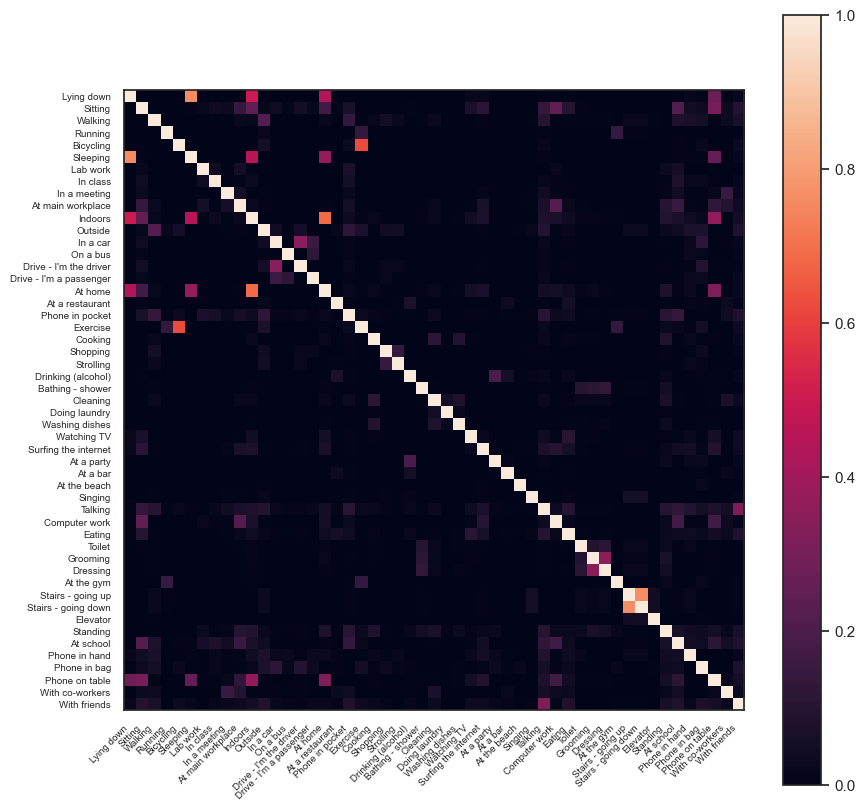

In [101]:
from matplotlib import pyplot as plt
J = jaccard_similarity_for_label_pairs(y);

print("Label-pairs with higher color value tend to occur together more.");

fig = plt.figure(figsize=(10,10),facecolor='white');
ax = plt.subplot(1,1,1);
plt.imshow(J,interpolation='none');plt.colorbar();

pretty_label_names = [get_label_pretty_name(label) for label in label_names];
n_labels = len(label_names);
ax.set_xticks(range(n_labels));
ax.set_xticklabels(pretty_label_names,rotation=45,ha='right',fontsize=7);
ax.set_yticks(range(n_labels));
ax.set_yticklabels(pretty_label_names,fontsize=7);

In [102]:
for i in range(len(J)):
    for j in range(len(J[i])):
       if(1>J[i][j]>0.30):
        print('Labels:',label_names[i],label_names[j],J[i][j])

Labels: LYING_DOWN SLEEPING 0.7580431660079422
Labels: LYING_DOWN OR_indoors 0.5020771050510827
Labels: LYING_DOWN LOC_home 0.4346089033222851
Labels: SITTING PHONE_ON_TABLE 0.30372302633967235
Labels: BICYCLING OR_exercise 0.6212102462566514
Labels: SLEEPING LYING_DOWN 0.7580431660079422
Labels: SLEEPING OR_indoors 0.44969462672990707
Labels: SLEEPING LOC_home 0.36738857046820395
Labels: OR_indoors LYING_DOWN 0.5020771050510827
Labels: OR_indoors SLEEPING 0.44969462672990707
Labels: OR_indoors LOC_home 0.6908112873012852
Labels: OR_indoors PHONE_ON_TABLE 0.37123655545033235
Labels: IN_A_CAR DRIVE_-_I_M_THE_DRIVER 0.34991357787593624
Labels: DRIVE_-_I_M_THE_DRIVER IN_A_CAR 0.34991357787593624
Labels: LOC_home LYING_DOWN 0.4346089033222851
Labels: LOC_home SLEEPING 0.36738857046820395
Labels: LOC_home OR_indoors 0.6908112873012852
Labels: LOC_home PHONE_ON_TABLE 0.31841197514036446
Labels: OR_exercise BICYCLING 0.6212102462566514
Labels: TALKING WITH_FRIENDS 0.31652177664646114
Labels: 

In [58]:
## Merge Multiple 1M Rows CSV files
import os
import pandas as pd
import pandas as pd
import gzip
import csv
path="C:/Users/Adwait/Desktop/Behavior recognition/ExtraSensoryData/"
# 2. creates list with files to merge based on name convention
file_list = [path + f for f in os.listdir(path) if f.endswith('.csv')]

# 3. creates empty list to include the content of each file converted to pandas DF
csv_list = []
 
# 4. reads each (sorted) file in file_list, converts it to pandas DF and appends it to the csv_list
for file in sorted(file_list):
    csv_list.append(pd.read_csv(file).assign(File_Name = os.path.basename(file)))

# 5. merges single pandas DFs into a single DF, index is refreshed 
csv_merged = pd.concat(csv_list, ignore_index=True)

# 6. Single DF is saved to the path in CSV format, without index column
csv_merged.to_csv(path + 'combined.csv', index=False)